In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_19416/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

(array([0., 1.]), array([35052, 34948]))


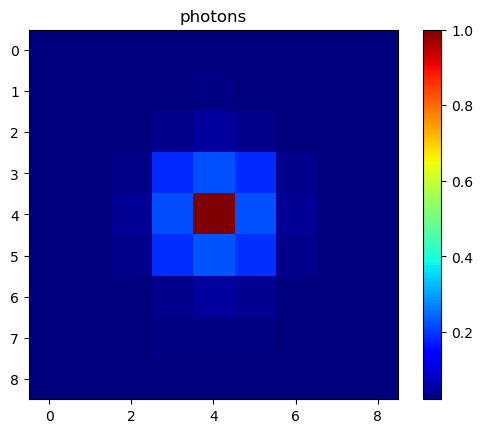

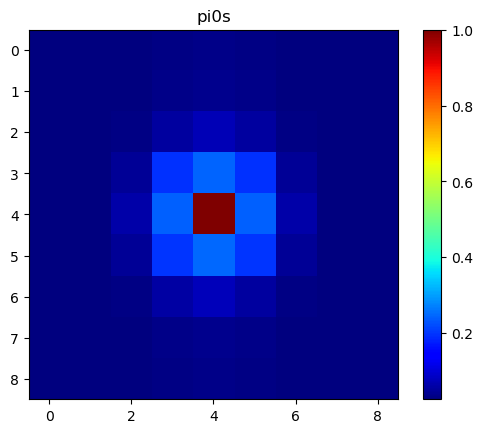

In [3]:
### visualise the dataset
dataset = np.loadtxt("output0.csv")
print(np.unique(dataset[:,81],return_counts=True))
pis = dataset[:,:81][dataset[:,81] == 0]
phos = dataset[:,:81][dataset[:,81] == 1]
from matplotlib import colors
im1 = plt.imshow(np.mean(phos.reshape(...),axis=0),cmap='jet')#,norm=colors.LogNorm())
plt.colorbar(im1)
plt.title("photons")
plt.show()
im2 = plt.imshow(np.mean(pis.reshape(...),axis=0),cmap='jet')#,norm=colors.LogNorm())
plt.colorbar(im2)
plt.title("pi0s")
plt.show()

In [4]:
## define dataset

from torch.utils.data import Dataset
import torch_geometric
from torch_geometric.data import Data
class ClassificationDataset_PCPYG(Dataset):
    def __init__(self, filename, k):
        
        self.filename_ = filename
        self.data = np.loadtxt(self.filename_)
        self.imageflat = torch.tensor(self.data[:,:81],dtype=torch.float) ## Ns x Npix
        self.images = torch.reshape(...) ## Ns X [9x9]
        self.labels = torch.tensor(self.data[:,81],dtype=torch.double)
        self.k = k
        self.pc_dataset = [ self.transform_2d_img_to_point_cloud(self.images[idx],self.labels[idx]) for idx in range(len(self.imageflat)) ]
        #self.pc = torch.stack([i['point'] for i in self.pc_dataset],dim=0)
        
    
    def transform_2d_img_to_point_cloud(self, image, label) :
    
        img, label = image, label
        #img_array = img[0]
        values = ... ## only consider crystals which have >0 energy (no padding B))
        x_coord = torch.argwhere(img > 0.)[...] ## get x coordinate . should we normalise?
        y_coord = torch.argwhere(img > 0.)[...]
        
        point_vec = torch.stack( ..., dim=-1) ## what is a point cloud?
        
        
        edge_index = torch_geometric.nn.pool.knn_graph(x = ..., k = self.k)  ## how do we build adjacencies? 
        
        return {'point' : point_vec, 'label' : label, 'seq_length' : len(point_vec), 'edges' : edge_index}

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        data = Data(...) ## create a torch geomwtric data
        data.label = self.pc_dataset[idx]['label']
        data.edge_index = self.pc_dataset[idx]['edges']
        
        return data
    


In [5]:
### create dataset, dataloaders
train_datasetPYG = ClassificationDataset_PCPYG("output0.csv", k=3)
test_datasetPYG = ClassificationDataset_PCPYG("output1.csv", k=3)


In [4]:
train_datasetPYG[3].edge_index
import networkx as nx

evt = 0
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(train_datasetPYG[evt], to_undirected=False)
nx.draw_networkx(g, pos = {i:j[:2].tolist() for i,j in enumerate(train_datasetPYG[evt].x)},node_size=[i*100 for i in train_datasetPYG[evt].x[:,2].tolist()] , with_labels=False)

NameError: name 'train_datasetPYG' is not defined

In [7]:
ntrainbatch = 2000
ntestbatch = 2000
#from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
trainloaderPYG = DataLoader(train_datasetPYG, batch_size=ntrainbatch)
testloaderPYG = DataLoader(test_datasetPYG, batch_size=ntestbatch)

In [8]:
### define GNN models
from typing import Optional, Tuple
from typing import Callable, Union
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph, global_max_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn
from torch import Tensor
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
    PairTensor
)

    
    
class EdgeConv_xixj(MessagePassing):
    ## torch.cat([x_i, x_j - x_i], dim=-1)) -> torch.cat([x_i, x_j], dim=-1))
    r"""The edge convolutional operator from the `"Dynamic Graph CNN for
    Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)}
        h_{\mathbf{\Theta}}(\mathbf{x}_i \, \Vert \,
        \mathbf{x}_j - \mathbf{x}_i),

    where :math:`h_{\mathbf{\Theta}}` denotes a neural network, *.i.e.* a MLP.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            :obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.*, defined by :class:`torch.nn.Sequential`.
        aggr (str, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"max"`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    def __init__(self, nn: Callable, aggr: str = 'max', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.nn = nn
#        self.reset_parameters()

#    def reset_parameters(self):
#        super().reset_parameters()
#        reset(self.nn)


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x, size=None)


    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'
    
    
    
class EdgeConv_default(MessagePassing):
    r"""The edge convolutional operator from the `"Dynamic Graph CNN for
    Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)}
        h_{\mathbf{\Theta}}(\mathbf{x}_i \, \Vert \,
        \mathbf{x}_j - \mathbf{x}_i),

    where :math:`h_{\mathbf{\Theta}}` denotes a neural network, *.i.e.* a MLP.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            :obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.*, defined by :class:`torch.nn.Sequential`.
        aggr (str, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"max"`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    def __init__(self, nn: Callable, aggr: str = 'max', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.nn = nn
#        self.reset_parameters()

#    def reset_parameters(self):
#        super().reset_parameters()
#        reset(self.nn)


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x, size=None)


    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([...], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'



In [21]:
### edgeconv with predef edges

### not really edgeconv torch.cat([x_i, x_j - x_i], dim=-1)) -> torch.cat([x_i, x_j], dim=-1))  but with predef edges  
class EdgeconvNetwork_xixj(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add'):
        
        super(EdgeconvNetwork_xixj, self).__init__()
        self.k = k
        start_width =  hidden_dim ##
        middle_width = 3 * hidden_dim // 2
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(negative_slope=0.4),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        
        
        
                
        self.edgeconv1 = EdgeConv_xixj(..., aggr=aggr)
        self.edgeconv2 = EdgeConv_xixj(..., aggr=aggr)
        

        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear(hidden_dim, (hidden_dim)//2),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear((hidden_dim)//2, output_dim)
                                    
                                   )
        
        
        
    def forward(self, data):
        #print(data.x.shape,data.edge_index)
        data.x = self.inputnet(data.x)
        data.x = self.edgeconv1(...)
        data.x = self.edgeconv2(...)
        
        
        
        x = global_max_pool(...) ## how to get graph level prediction
        return F.log_softmax(self.output(x), dim=-1)#.squeeze(-1)







class EdgeconvNetwork(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add'):
        
        super(EdgeconvNetwork, self).__init__()
        self.k = k
        start_width =  hidden_dim ##
        middle_width = 3 * hidden_dim // 2 
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(negative_slope=0.4),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        
        
                
        self.edgeconv1 = EdgeConv_default(..., aggr=aggr)
        self.edgeconv2 = EdgeConv_default(..., aggr=aggr)
        

        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear(hidden_dim, (hidden_dim)//2),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear((hidden_dim)//2, output_dim)
                                    
                                   )
        
        
        
    def forward(self, data):
        #print(data.x.shape,data.edge_index)
        data.x = self.inputnet(data.x)
        data.x = self.edgeconv1(...)
        data.x = self.edgeconv2(...)
        
        
        
        x = global_max_pool(...) ## how to get graph level prediction
        return F.log_softmax(self.output(x), dim=-1)#.squeeze(-1)
    
    
    
    
### edgeconv with dynamic edges    
class EdgeconvNetwork_dyn(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add'):
        
        super(EdgeconvNetwork_dyn, self).__init__()
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(negative_slope=0.4),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
        convnn4 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.LeakyReLU(negative_slope=0.4),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.LeakyReLU(negative_slope=0.4)
                                )
                
        self.edgeconv1 = EdgeConv_default(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv_default(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv_default(nn=convnn3, aggr=aggr)
        self.edgeconv4 = EdgeConv_default(nn=convnn4, aggr=aggr)

        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear(hidden_dim, (hidden_dim)//2),
                                    nn.LeakyReLU(negative_slope=0.4),
                                    nn.Linear((hidden_dim)//2, output_dim)
                                    
                                   )
        
        
        
    def forward(self, data):
        #print(data.x.shape,data.edge_index)
        data.edge_index = knn_graph(...) ### where do you want to build the first adjacency?
        data.x = self.inputnet(data.x)
        data.x = self.edgeconv1(data.x, data.edge_index)
        data.edge_index = knn_graph(data.x, self.k, data.batch)
        data.x = self.edgeconv2(data.x, data.edge_index)
        data.edge_index = knn_graph(data.x, self.k, data.batch)
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        
        x = global_max_pool(data.x, data.batch)
        return F.log_softmax(self.output(x), dim=-1)#.squeeze(-1)


In [24]:
### define training and testing functions

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)

#model = EdgeconvNetwork(input_dim=3, hidden_dim=5, output_dim=2, k=16, aggr='add')
model = EdgeconvNetwork_xixj(input_dim=..., hidden_dim=..., output_dim=..., k=16, aggr='add')
#model = EdgeconvNetwork_dyn(input_dim=3, hidden_dim=5, output_dim=2, k=3, aggr='add')
model = model.to(device)


optimizer = torch.optim.AdamW(..., lr=1e-3, weight_decay=1e-3)  ## what does the optimiser do


def train(epoch):
    model.train()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(trainloaderPYG):  ### change to loaderDNN for DNN
            data = data.to(device)
            label = data.label.to(torch.long)
            optimizer.zero_grad()
            result = model(data)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloaderPYG): ### change to loaderDNN for DNN
            data = data.to(device)
            label = data.label.to(torch.long)
            result = model(data)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

In [ ]:
### loop over the datset and train/test

from tqdm import tqdm as tqdm
nepoch=20
best_loss = 99999999
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    trainl = train(epoch)
    losst.append(trainl[0])
    acct.append(trainl[1])
    testl = test(epoch)
    loss_epoch = testl[0]
    lossv.append(loss_epoch)
    accv.append(testl[1])
    epochs.append(epoch)

    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        plt.title("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        plt.plot(np.array(epochs),np.array(acct),c='b',label='training')
        plt.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        plt.legend()
        plt.title("accuracy")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
    #break

In [27]:
def visualize_samples(data, label, marker='o'):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
        
    plt.figure(figsize=(4,4))
    plt.scatter(data[:,0] , data[:,1], edgecolor="#333",s =data[:,2]*100 , marker=marker, label="Class " + str(label))
    
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

  0%|          | 0/70000 [00:00<?, ?it/s]


torch.Size([81, 3])


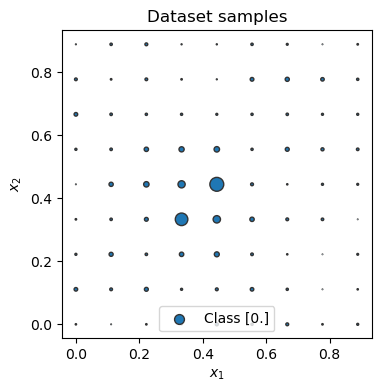

In [29]:
trainloaderPYG_t = DataLoader(train_datasetPYG, batch_size=1)
for data in tqdm(trainloaderPYG_t):  ### change to loaderDNN for DNN
            
            visualize_samples(data.x,data.label)
            
            print(data.x.shape,)
            break